In [2]:
%pip install xgboost matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
response = requests.get("https://financialmodelingprep.com/api/v3/stock/list?apikey=d7c45cee4377332d4b278f8790abf774")
data = response.json()

In [7]:
all_stocks = pd.DataFrame(data)
all_stocks["price"].fillna(0.0, inplace=True)
all_stocks["exchange"].fillna("", inplace=True)
all_stocks["price"] = all_stocks["price"].astype(float)
str_match = ["nasdaq", "new york"]
pattern = '|'.join(str_match)
all_stocks['exchange'] = all_stocks['exchange'].str.lower().str.strip()
us_stocks = all_stocks[all_stocks['exchange'].str.contains(pattern, regex=True, case=False)]
stocks_under_10 = us_stocks[(us_stocks["price"] < 10) & (us_stocks["type"] == "stock")]
stocks_under_10.head()

/var/folders/fd/hktpb8sd5hl6_jmpprfrhy380000gn/T/ipykernel_1639/1546297870.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_stocks["price"].fillna(0.0, inplace=True)
/var/folders/fd/hktpb8sd5hl6_jmpprfrhy380000gn/T/ipykernel_1639/1546297870.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

,symbol,name,price,exchange,exchangeShortName,type
4280,NOVA,Sunnova Energy International Inc.,5.33,new york stock exchange,NYSE,stock
4288,HOUS,Anywhere Real Estate Inc.,3.19,new york stock exchange,NYSE,stock
4289,DOUG,Douglas Elliman Inc.,1.11,new york stock exchange,NYSE,stock
4293,ENZ,"Enzo Biochem, Inc.",1.16,new york stock exchange,NYSE,stock
4295,NIO,NIO Inc.,4.33,new york stock exchange,NYSE,stock


In [8]:
len(stocks_under_10)

4639

In [51]:
def get_stock_data(ticker):
    response = requests.get(f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey=d7c45cee4377332d4b278f8790abf774")
    data = response.json()
    stock_data = pd.DataFrame(data['historical'])
    return stock_data

In [52]:
def create_features(data):
    data['sma_20'] = data['close'].rolling(window=20).mean()
    data['sma_50'] = data['close'].rolling(window=50).mean()
    
    data['ema_12'] = data['close'].ewm(span=12, adjust=False).mean()
    data['ema_26'] = data['close'].ewm(span=26, adjust=False).mean()
    
    data['std_dev'] = data['close'].rolling(window=20).std()
    data['bollinger_high'] = data['sma_20'] + (data['std_dev'] * 2)
    data['bollinger_low'] = data['sma_20'] - (data['std_dev'] * 2)
    
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['rsi'] = 100 - (100 / (1 + rs))
    
    data['true_range'] = np.maximum(data['high'] - data['low'], 
                            np.maximum(abs(data['high'] - data['close'].shift(1)), 
                                       abs(data['low'] - data['close'].shift(1))))
    data['avg_true_range'] = data['true_range'].rolling(window=14).mean()
    
    data['on_balance_vol'] = (np.sign(data['close'].diff()) * data['volume']).fillna(0).cumsum()
    
    data = data.dropna()
    return data

In [53]:
def prepare_data(data):
    # Define the target_var variable (e.g., future return over next week)
    data['target_var'] = data['close'].shift(-7) / data['close'] - 1
    data = data.dropna()

    features = data[['sma_20', 'sma_50', 'ema_12', 'ema_26', 'bollinger_high', 'bollinger_low', 'rsi', 'avg_true_range', 'on_balance_vol']]
    target_var = data['target_var']

    X_train, X_test, y_train, y_test = train_test_split(features, target_var, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test

In [54]:
def train_model(X_train, y_train):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error: {mse}")
    return predictions

In [55]:
def generate_signals(data, model):
    data['predicted_return'] = model.predict(data[['sma_20', 'sma_50', 'ema_12', 'ema_26', 'bollinger_high', 'bollinger_low', 'rsi', 'avg_true_range', 'on_balance_vol']])
    data['signal'] = np.where(data['predicted_return'] > 0, 1, 0)
    data['positions'] = data['signal'].diff()
    return data

In [56]:
def backtest_strategy(data):
    initial_capital = float(100000.0)
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    portfolio = pd.DataFrame(index=data.index).fillna(0.0)

    positions['stock'] = data['signal']
    portfolio['positions'] = positions.multiply(data['adjClose'], axis=0)
    portfolio['cash'] = initial_capital - (positions.diff().multiply(data['adjClose'], axis=0)).cumsum()
    portfolio['total'] = portfolio['positions'] + portfolio['cash']
    portfolio['returns'] = portfolio['total'].pct_change()

    return portfolio

Mean Squared Error: 0.10736548866703405


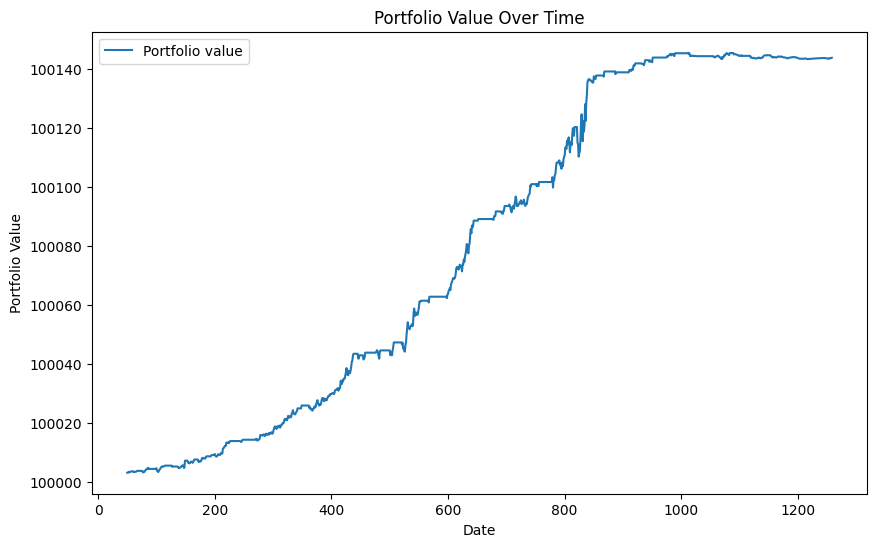

In [80]:
# Fetch data
ticker = 'PLUG'
data = get_stock_data(ticker)
data = create_features(data)

# Prepare data
X_train, X_test, y_train, y_test = prepare_data(data)

# true_rangeain model
model = train_model(X_train, y_train)

# Evaluate model
predictions = evaluate_model(model, X_test, y_test)

# Generate signals
data_with_signals = generate_signals(data, model)

# Backtest strue_rangeategy
portfolio = backtest_strategy(data_with_signals)

# Plot portfolio value
plt.figure(figsize=(10, 6))
plt.plot(portfolio['total'], label='Portfolio value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

In [85]:
def get_latest_signal(data):
    if data.empty:
        return "No data available to generate a signal"
    print(data.head())
    latest_data = data.iloc[0]
    # print(latest_data)
    signal = latest_data['signal']
    if signal == 1:
        return "Buy"
    else:
        return "Sell"

In [86]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def predict_future_returns(ticker, model):
    # Fetch recent data
    today = datetime.now().strftime("%Y-%m-%d")
    one_year_ago = (datetime.now() - relativedelta(years=1)).strftime("%Y-%m-%d")
    response = requests.get(f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={one_year_ago}&to={today}&apikey=d7c45cee4377332d4b278f8790abf774")
    data = response.json()
    df = pd.DataFrame(data['historical'])
    recent_data = create_features(df)

    # Predict future returns
    recent_data['predicted_return'] = model.predict(recent_data[['sma_20', 'sma_50', 'ema_12', 'ema_26', 'bollinger_high', 'bollinger_low', 'rsi', 'avg_true_range', 'on_balance_vol']])
    recent_data['signal'] = np.where(recent_data['predicted_return'] > 0, 1, 0)
    todays_signal = get_latest_signal(recent_data)
    print(f"Today's signal for ticker {ticker}: {todays_signal}")

    return recent_data

# Example usage
recent_predictions = predict_future_returns('PLUG', model)

          date  open  high   low  close  adjClose    volume  unadjustedVolume  \
49  2024-04-05  3.00  3.19  2.99   3.14      3.14  30415894          30415894   
50  2024-04-04  3.29  3.40  3.14   3.15      3.15  24158197          24158197   
51  2024-04-03  3.16  3.24  3.05   3.23      3.23  27406038          27406038   
52  2024-04-02  3.35  3.35  3.12   3.14      3.14  31010064          31010064   
53  2024-04-01  3.49  3.50  3.29   3.44      3.44  18261543          18261543   

    change  changePercent  ...    ema_26   std_dev  bollinger_high  \
49    0.14           4.67  ...  2.841611  0.302729        3.291959   
50   -0.14          -4.26  ...  2.864455  0.314195        3.349891   
51    0.07           2.22  ...  2.891532  0.317334        3.402669   
52   -0.21          -6.27  ...  2.909937  0.308434        3.426367   
53   -0.05          -1.43  ...  2.949201  0.323082        3.507664   

    bollinger_low        rsi  true_range  avg_true_range  on_balance_vol  \
49       2.08104

/var/folders/fd/hktpb8sd5hl6_jmpprfrhy380000gn/T/ipykernel_98572/2099720172.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['predicted_return'] = model.predict(recent_data[['sma_20', 'sma_50', 'ema_12', 'ema_26', 'bollinger_high', 'bollinger_low', 'rsi', 'avg_true_range', 'on_balance_vol']])
/var/folders/fd/hktpb8sd5hl6_jmpprfrhy380000gn/T/ipykernel_98572/2099720172.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['signal'] = np.where(recent_data['predicted_return'] > 0, 1, 

          date   open   high    low  close  adjClose    volume  \
49  2024-04-05  13.27  13.40  13.09  13.28     13.12  46937362   
50  2024-04-04  13.90  13.95  13.17  13.21     13.05  67812379   
51  2024-04-03  13.25  13.68  13.23  13.65     13.49  57498871   
52  2024-04-02  13.16  13.37  13.09  13.28     13.12  42653403   
53  2024-04-01  13.33  13.38  13.14  13.29     13.13  35898334   

    unadjustedVolume  change  changePercent  ...   sma_50     ema_12  \
49          46937362    0.01       0.075358  ...  12.3454  12.902537   
50          67812379   -0.69      -4.960000  ...  12.3754  12.949839   
51          57498871    0.40       3.020000  ...  12.4096  13.057556   
52          42653403    0.12       0.911850  ...  12.4336  13.091778   
53          35898334   -0.04      -0.300080  ...  12.4572  13.122274   

       ema_26   std_dev  bollinger_high  bollinger_low        rsi  true_range  \
49  12.650451  0.482411       13.649323      11.719677  54.347826        0.32   
50  12.6

/var/folders/fd/hktpb8sd5hl6_jmpprfrhy380000gn/T/ipykernel_98572/3890948586.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['predicted_return'] = model.predict(recent_data[['sma_20', 'sma_50', 'ema_12', 'ema_26', 'bollinger_high', 'bollinger_low', 'rsi', 'avg_true_range', 'on_balance_vol']])
/var/folders/fd/hktpb8sd5hl6_jmpprfrhy380000gn/T/ipykernel_98572/3890948586.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['signal'] = np.where(recent_data['predicted_return'] > 0, 1, 

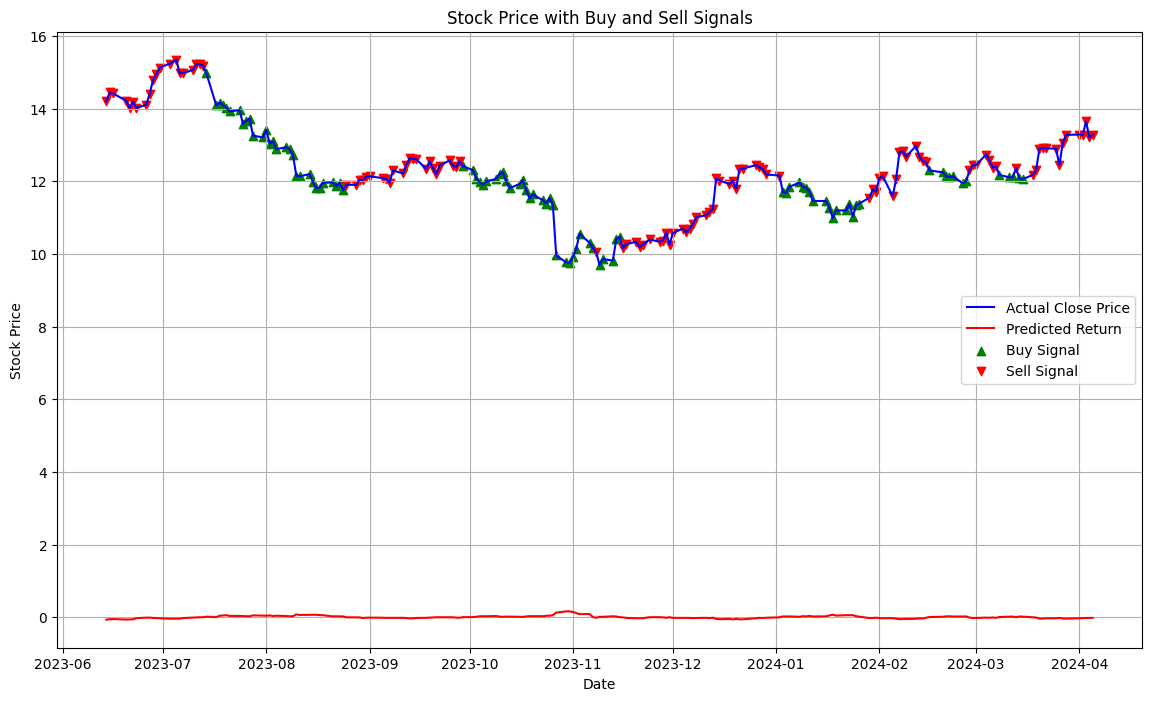

In [62]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def visualize_predictions(data):
    # Ensure the date column is in datetime format and set it as the index
    if not pd.api.types.is_datetime64_any_dtype(data.iloc[:, 0]):
        data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0])
    data.set_index(data.columns[0], inplace=True)
    
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['close'], label='Actual Close Price', color='blue')
    plt.plot(data.index, data['predicted_return'], label='Predicted Return', color='red')

    # Mark buy signals
    buy_signals = data[data['signal'] == 1]
    plt.scatter(buy_signals.index, buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1)

    # Mark sell signals
    sell_signals = data[data['signal'] == 0]
    plt.scatter(sell_signals.index, sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1)

    # Set monthly locator and formatter for x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.title('Stock Price with Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# Assuming `predict_future_returns` is defined elsewhere and 'F' is a valid stock symbol
recent_predictions = predict_future_returns('F', model)
visualize_predictions(recent_predictions)